In [2]:
# Goal: Estimate expansion velocity from the BB velocity
import sys, os, functools
import warnings
warnings.filterwarnings("ignore", module="dynesty.sampling")
warnings.filterwarnings("ignore", module="speclite.filters")
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import astropy.constants as aconst
import astropy.units as u
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
import astropy.table as table
from astropy.cosmology import Planck15 as cosmology
import seaborn
import pandas as pd
from astropy.modeling import models, fitting

try:
    import snelib19odp
except ImportError:
    sys.path.append('../lib')
import snelib19odp.dataset as dataset
import snelib19odp.blackbody as blackbody
import snelib19odp.analysis.blackbody as bbfit

In [3]:
CM_TO_RSUN = u.cm.to(u.Rsun)

def fit_bb(ds, bands, fine=False):
    mjd_peak = ds.transient.prior_t0
    label = f"{ds.transient.name} {bands}"
    data = bbfit.run_observation_grid(ds, bands, progressbar=False, fine_pre_peak_grid=fine)
    
    mjd_grid = np.array([x.mjd for x in data])
    rads = np.empty_like(mjd_grid)
    rad_errs = np.empty_like(mjd_grid)
    for i, mjd in enumerate(mjd_grid):
        #obs_mags, obs_mags_errs, sampler, results = data[i]
        results = data[i].results
        samples, weights = results.samples, np.exp(results.logwt - results.logz[-1])
        trace = dyfunc.resample_equal(samples, weights)
        #temps[i], temp_errs[i] = np.mean(trace[:,0]), np.std(trace[:,0])
        t_rads = np.exp(trace[:,1])*CM_TO_RSUN
        rads[i], rad_errs[i] = np.mean(t_rads), np.std(t_rads)
    return mjd_grid, rads, rad_errs

/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


<ErrorbarContainer object of 3 artists>

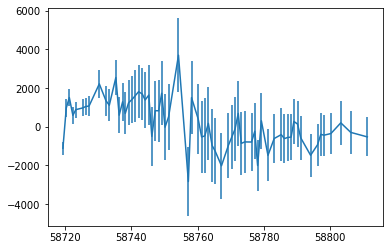

In [4]:
mjd, radii, radii_err = fit_bb(dataset.load_dataset('SN2019odp_phot'), 'gri')
plt.errorbar(mjd[1:], np.diff(radii), yerr=radii_err[1:])

In [5]:
mjd, radii, radii_err = fit_bb(dataset.load_dataset('SN2019odp_phot'), 'gri')

model_poly = models.Polynomial1D(degree=3)

# select data
idx = mjd < dataset.load_dataset('SN2019odp_phot').transient.prior_t0 + 20
x = mjd[idx]
y = radii[idx]
yerr = radii_err[idx]

fitter_poly = fitting.LinearLSQFitter() 
best_fit_poly = fitter_poly(model_poly, x, y, weights = 1.0/yerr**2)

plt.plot(mjd, best_fit_poly(mjd))
plt.errorbar(mjd, radii, yerr=radii_err);
print(best_fit_poly)
print(best_fit_poly.c1.value*u.Rsun.to(u.km)/(u.d.to(u.s)))

/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 3
Parameters:
            c0                 c1                  c2                    c3         
    ------------------ ----------------- --------------------- ---------------------
    -48372772.50153318 823.8576186681012 8.137845615581242e-12 6.028759803140287e-26
6633.770200317106


 [astropy.modeling.fitting]


/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 3
Parameters:
             c0                 c1                 c2                 c3        
    ------------------- ----------------- ------------------- ------------------
    -185875281891253.94 9496058712.606161 -161712.61673297352 0.9179587814028533
76463056092.13086


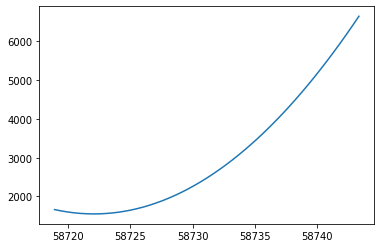

In [6]:
mjd, radii, radii_err = fit_bb(dataset.load_dataset('SN2019odp_phot'), 'ri')

model_poly = models.Polynomial1D(degree=3)

# select data
idx = mjd < dataset.load_dataset('SN2019odp_phot').transient.prior_t0 + 10
x = mjd[idx]
y = radii[idx]
yerr = radii_err[idx]

#fitter_poly = fitting.LinearLSQFitter() 
fitter_poly = fitting.LevMarLSQFitter()
best_fit_poly = fitter_poly(model_poly, x, y, weights = 1.0/yerr**2)

#plt.plot(x, best_fit_poly(x))
#plt.errorbar(x, y, yerr=yerr);
mjd = np.linspace(x.min(), x.max())
plt.plot(mjd[1:], np.diff(best_fit_poly(mjd)) * u.Rsun.to(u.km)/(u.d.to(u.s)))
print(best_fit_poly)
print(best_fit_poly.c1.value*u.Rsun.to(u.km)/(u.d.to(u.s)))
#plt.yscale('log')

/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 3
Parameters:
             c0                 c1                 c2                   c3         
    ------------------- ----------------- ------------------- ---------------------
    -51973042.987666085 885.1992763934879 8.7440645799821e-12 6.478088981650995e-26
7127.698340126732


 [astropy.modeling.fitting]


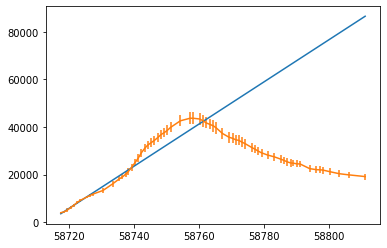

In [7]:
mjd, radii, radii_err = fit_bb(dataset.load_dataset('SN2019odp_phot'), 'gr')

model_poly = models.Polynomial1D(degree=3)

# select data
idx = mjd < dataset.load_dataset('SN2019odp_phot').transient.prior_t0 + 20
x = mjd[idx]
y = radii[idx]
yerr = radii_err[idx]

fitter_poly = fitting.LinearLSQFitter() 
best_fit_poly = fitter_poly(model_poly, x, y, weights = 1.0/yerr**2)

plt.plot(mjd, best_fit_poly(mjd))
plt.errorbar(mjd, radii, yerr=radii_err);
print(best_fit_poly)
print(best_fit_poly.c1.value*u.Rsun.to(u.km)/(u.d.to(u.s)))

/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
 [astropy.modeling.fitting]


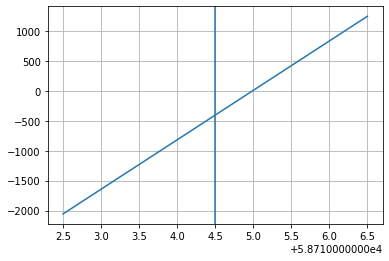

In [8]:
mjd, radii, radii_err = fit_bb(dataset.load_dataset('SN2019odp_phot'), 'gri')

model_poly = models.Polynomial1D(degree=3)

# select data
idx = mjd < dataset.load_dataset('SN2019odp_phot').transient.prior_t0 + 20
x = mjd[idx]
y = radii[idx]
yerr = radii_err[idx]

fitter_poly = fitting.LinearLSQFitter() 
best_fit_poly = fitter_poly(model_poly, x, y, weights = 1.0/yerr**2)

prior_texpl = dataset.load_dataset('SN2019odp_phot').transient.prior_texpl
texpl = prior_texpl + np.linspace(-2, 2)

plt.plot(texpl, best_fit_poly(texpl))
plt.axvline(prior_texpl)
plt.grid()

In [9]:
mjd, radii, radii_err = fit_bb(dataset.load_dataset('SN2019odp_phot'), 'ri')

model_poly = models.Polynomial1D(degree=3)

# select data
idx = mjd < dataset.load_dataset('SN2019odp_phot').transient.prior_t0 + 20
x = mjd[idx]
y = radii[idx]
yerr = radii_err[idx]

fitter_poly = fitting.LinearLSQFitter() 
best_fit_poly = fitter_poly(model_poly, x, y, weights = 1.0/yerr**2)

prior_texpl = dataset.load_dataset('SN2019odp_phot').transient.prior_texpl
texpl = prior_texpl + np.linspace(-2, 2)

plt.plot(texpl, best_fit_poly(texpl))
plt.axvline(prior_texpl)
plt.grid()

/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
 [astropy.modeling.fitting]
